In [11]:
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Load class name mapping
mapping_file = "imagenet_class_name_mapping.txt"
synset_to_name = {}
with open(mapping_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 3:
            synset_id = parts[0]
            class_name = parts[2].replace('_', ' ')
            synset_to_name[synset_id] = class_name

# Read CSV and extract data
csv_path = "imagenet_examples.csv"
with open(csv_path, "r") as f:
    content = f.read().strip()
    if content.startswith('"') and content.endswith('"'):
        content = content[1:-1]
    paths = [p.strip() for p in content.split(",") if p.strip()]

# Extract class info and assign bins
data = []
for idx, path in enumerate(paths):
    match = re.search(r'/([n]\d{8})/', path)
    class_id = match.group(1) if match else "unknown"
    class_name = synset_to_name.get(class_id, class_id)
    difficulty_bin = min(idx // 10000, 4)
    data.append({'class_name': class_name, 'difficulty_bin': difficulty_bin})

df = pd.DataFrame(data)
print(f"Loaded {len(df)} samples with {len(synset_to_name)} class mappings")


Loaded 50000 samples with 1000 class mappings


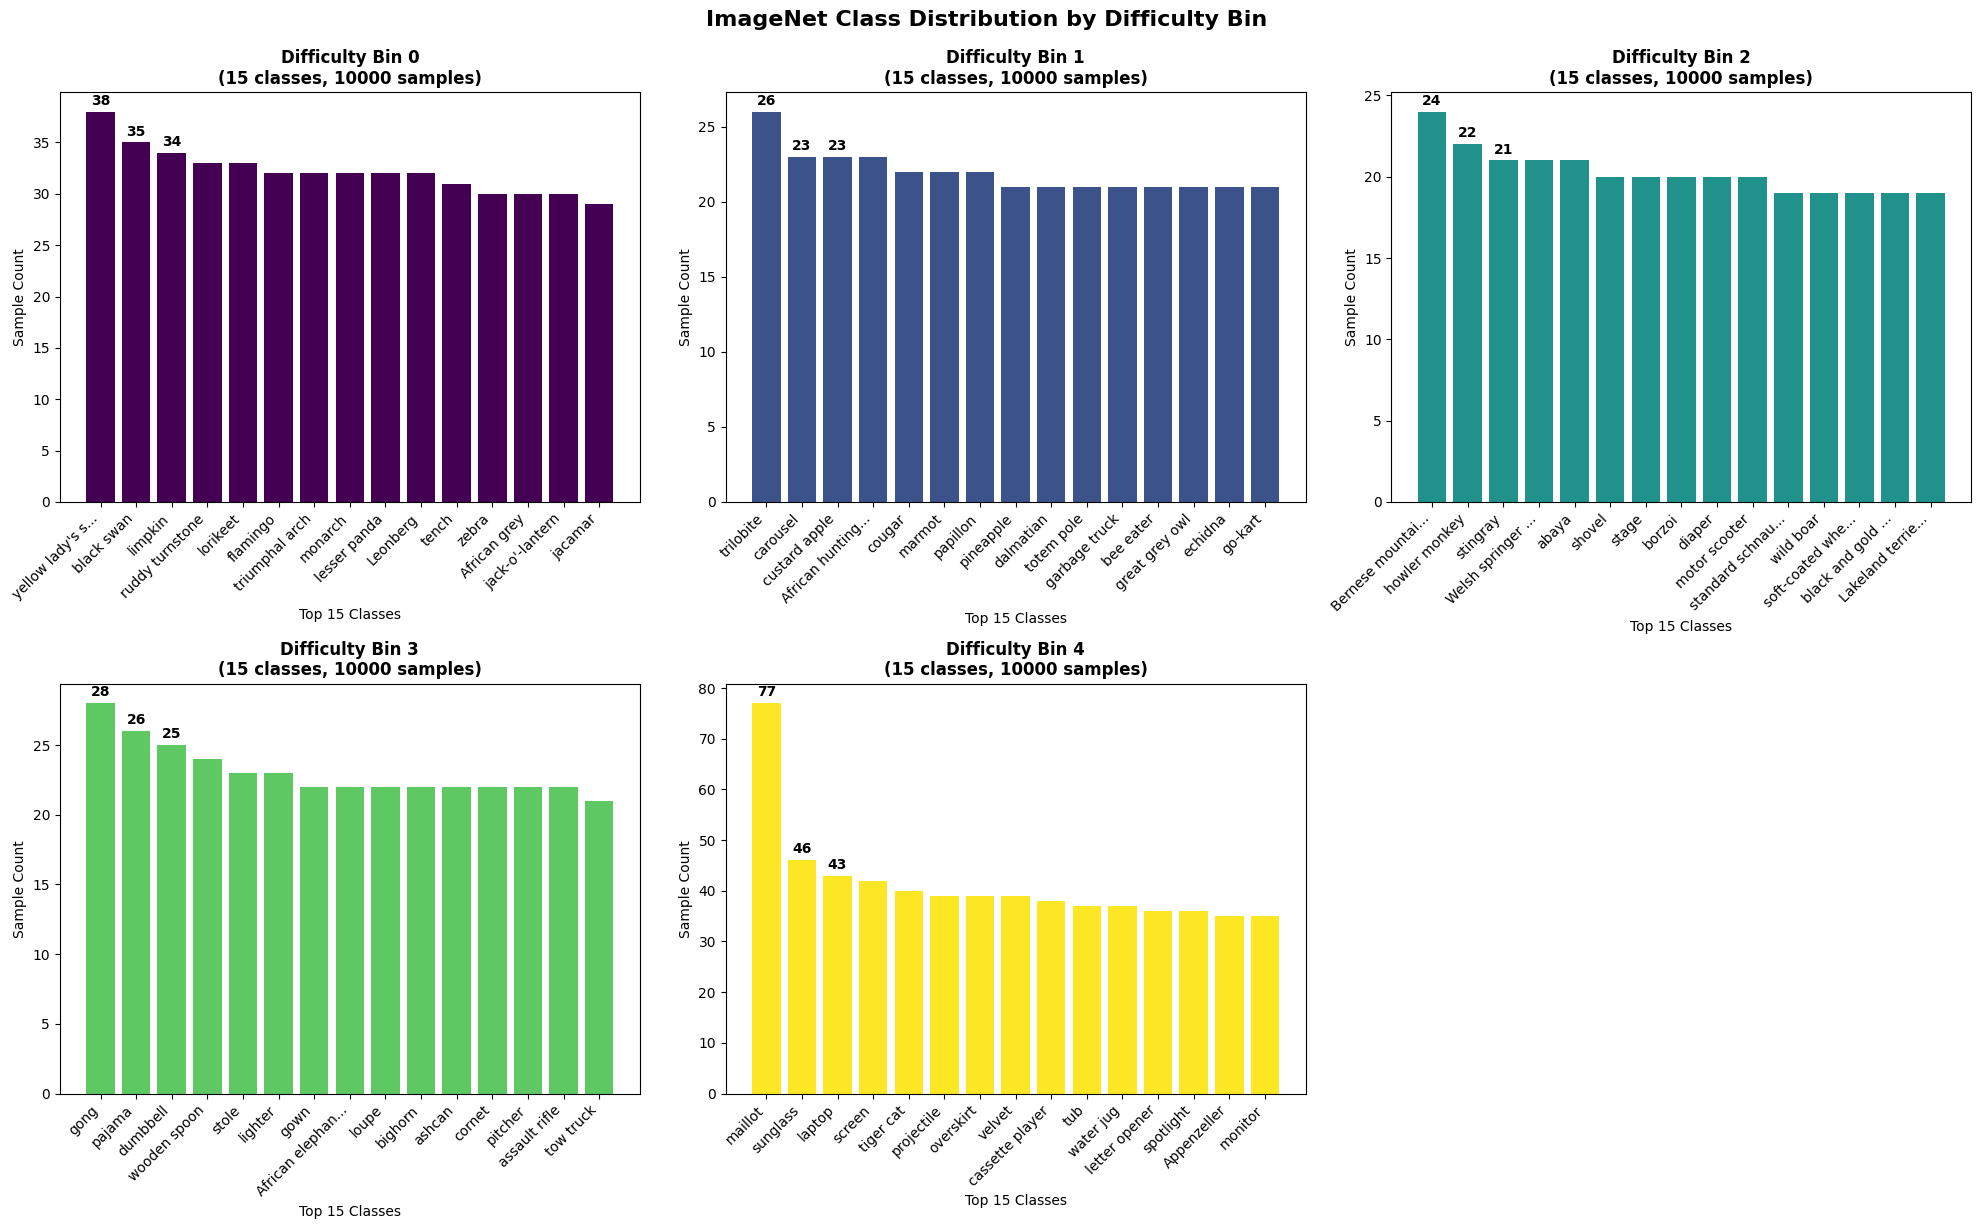

In [12]:
# Create 5 histograms
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for bin_idx in range(5):
    ax = axes[bin_idx]
    bin_data = df[df['difficulty_bin'] == bin_idx]
    
    if len(bin_data) > 0:
        class_counts = bin_data['class_name'].value_counts().head(15)
        
        ax.bar(range(len(class_counts)), class_counts.values, color=plt.cm.viridis(bin_idx / 4))
        ax.set_title(f'Difficulty Bin {bin_idx}\n({len(class_counts)} classes, {len(bin_data)} samples)', fontweight='bold')
        ax.set_xlabel('Top 15 Classes')
        ax.set_ylabel('Sample Count')
        
        # Truncate long names for display
        labels = [name[:15] + "..." if len(name) > 15 else name for name in class_counts.index]
        ax.set_xticks(range(len(class_counts)))
        ax.set_xticklabels(labels, rotation=45, ha='right')
        
        # Add count labels on top 3 bars
        for i in range(min(3, len(class_counts))):
            ax.text(i, class_counts.iloc[i] + max(class_counts.values) * 0.01, 
                   str(class_counts.iloc[i]), ha='center', va='bottom', fontweight='bold')

# Remove empty subplot
axes[5].remove()
plt.tight_layout()
plt.suptitle('ImageNet Class Distribution by Difficulty Bin', fontsize=16, fontweight='bold', y=1.02)
plt.show()


Total unique classes: 998


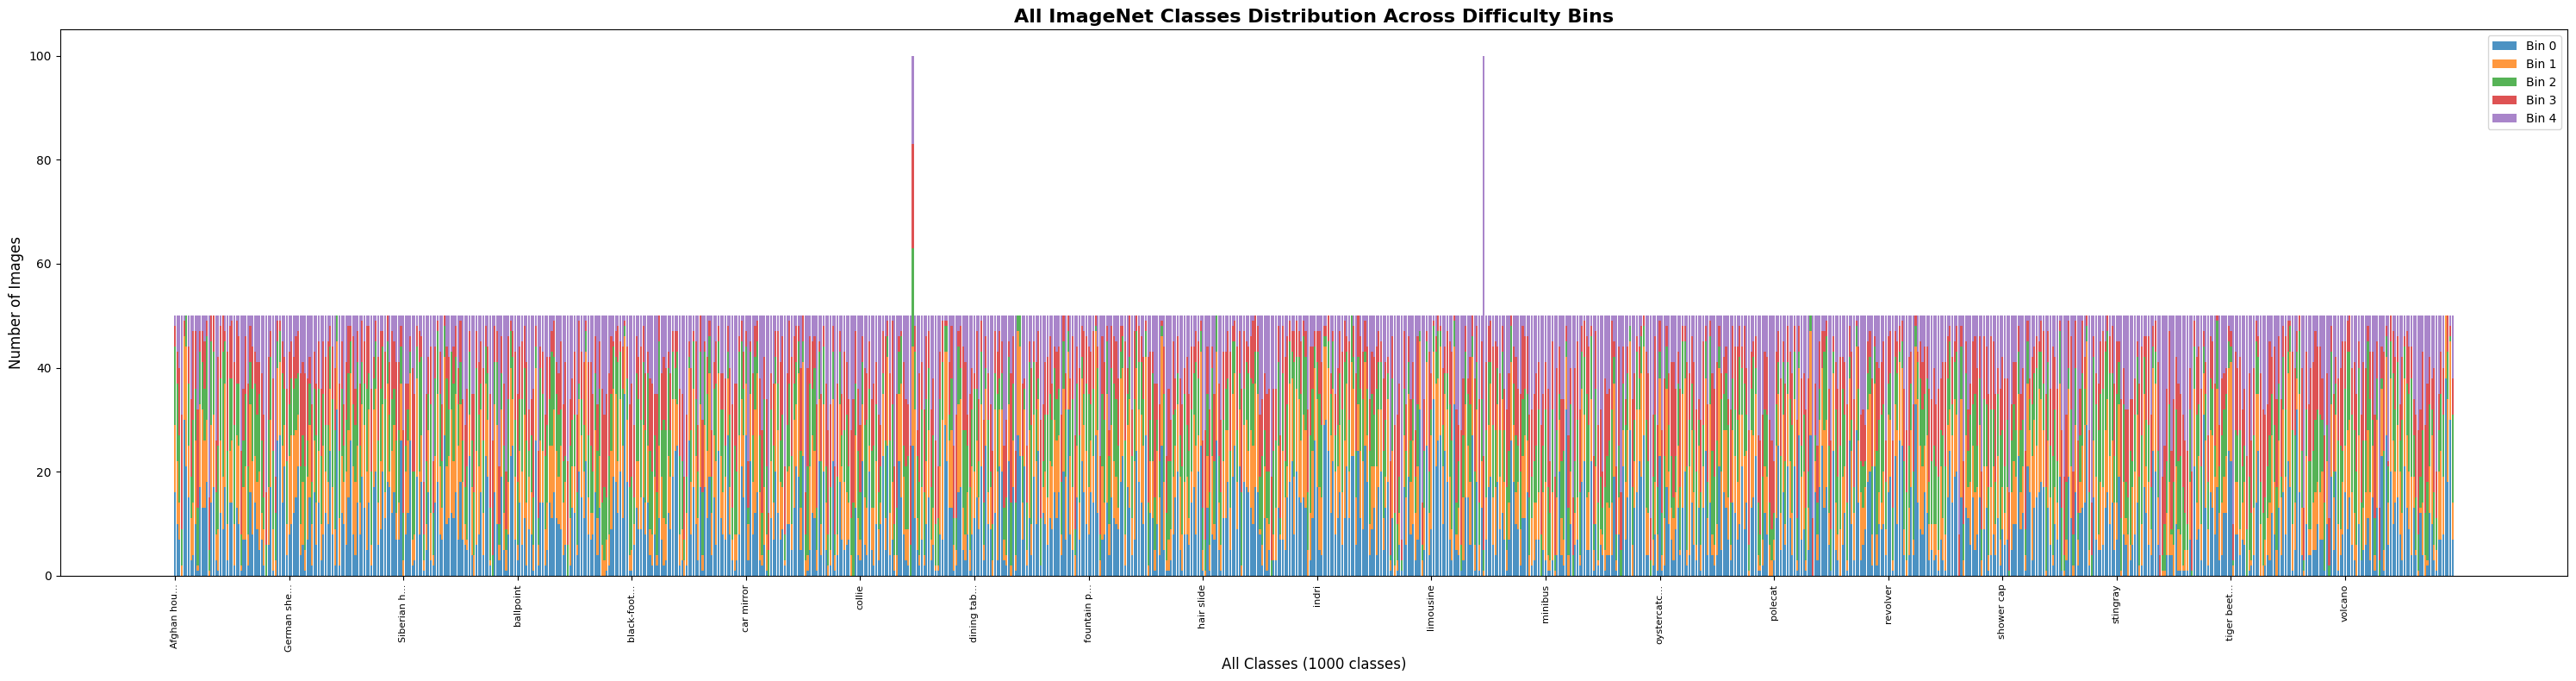

In [13]:
# Create histogram of ALL classes (x-axis = all 1000 classes, stacked by bins)
all_classes = sorted(df['class_name'].unique())
print(f"Total unique classes: {len(all_classes)}")

# Create a matrix: classes x bins
class_bin_matrix = []
class_names_for_plot = []

for class_name in all_classes:
    class_data = df[df['class_name'] == class_name]
    bin_counts = [len(class_data[class_data['difficulty_bin'] == i]) for i in range(5)]
    class_bin_matrix.append(bin_counts)
    class_names_for_plot.append(class_name)

# Create stacked bar chart
fig, ax = plt.subplots(1, 1, figsize=(30, 8))
bin_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

bottom = [0] * len(all_classes)
for bin_idx in range(5):
    counts = [class_bin_matrix[i][bin_idx] for i in range(len(all_classes))]
    ax.bar(range(len(all_classes)), counts, bottom=bottom, 
           label=f'Bin {bin_idx}', color=bin_colors[bin_idx], alpha=0.8)
    bottom = [bottom[i] + counts[i] for i in range(len(all_classes))]

ax.set_title('All ImageNet Classes Distribution Across Difficulty Bins', fontsize=16, fontweight='bold')
ax.set_xlabel('All Classes (1000 classes)', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.legend()

# Only show every 50th class name to avoid overcrowding
tick_positions = range(0, len(all_classes), 50)
tick_labels = [class_names_for_plot[i][:10] + "..." if len(class_names_for_plot[i]) > 10 else class_names_for_plot[i] 
               for i in tick_positions]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=90, fontsize=8)

plt.tight_layout()
plt.show()


Top 10 classes with highest minimum count across all bins:
1. crane: min=17, bins=[25, 19, 19, 20, 17]
2. Doberman: min=9, bins=[9, 9, 13, 10, 9]
3. bee: min=9, bins=[11, 9, 9, 12, 9]
4. boxer: min=9, bins=[9, 10, 9, 11, 11]
5. chain mail: min=9, bins=[10, 10, 9, 10, 11]
6. electric ray: min=9, bins=[10, 12, 10, 9, 9]
7. espresso maker: min=9, bins=[10, 10, 11, 10, 9]
8. marmoset: min=9, bins=[9, 10, 9, 11, 11]
9. padlock: min=9, bins=[10, 10, 9, 10, 11]
10. radiator: min=9, bins=[12, 9, 10, 10, 9]


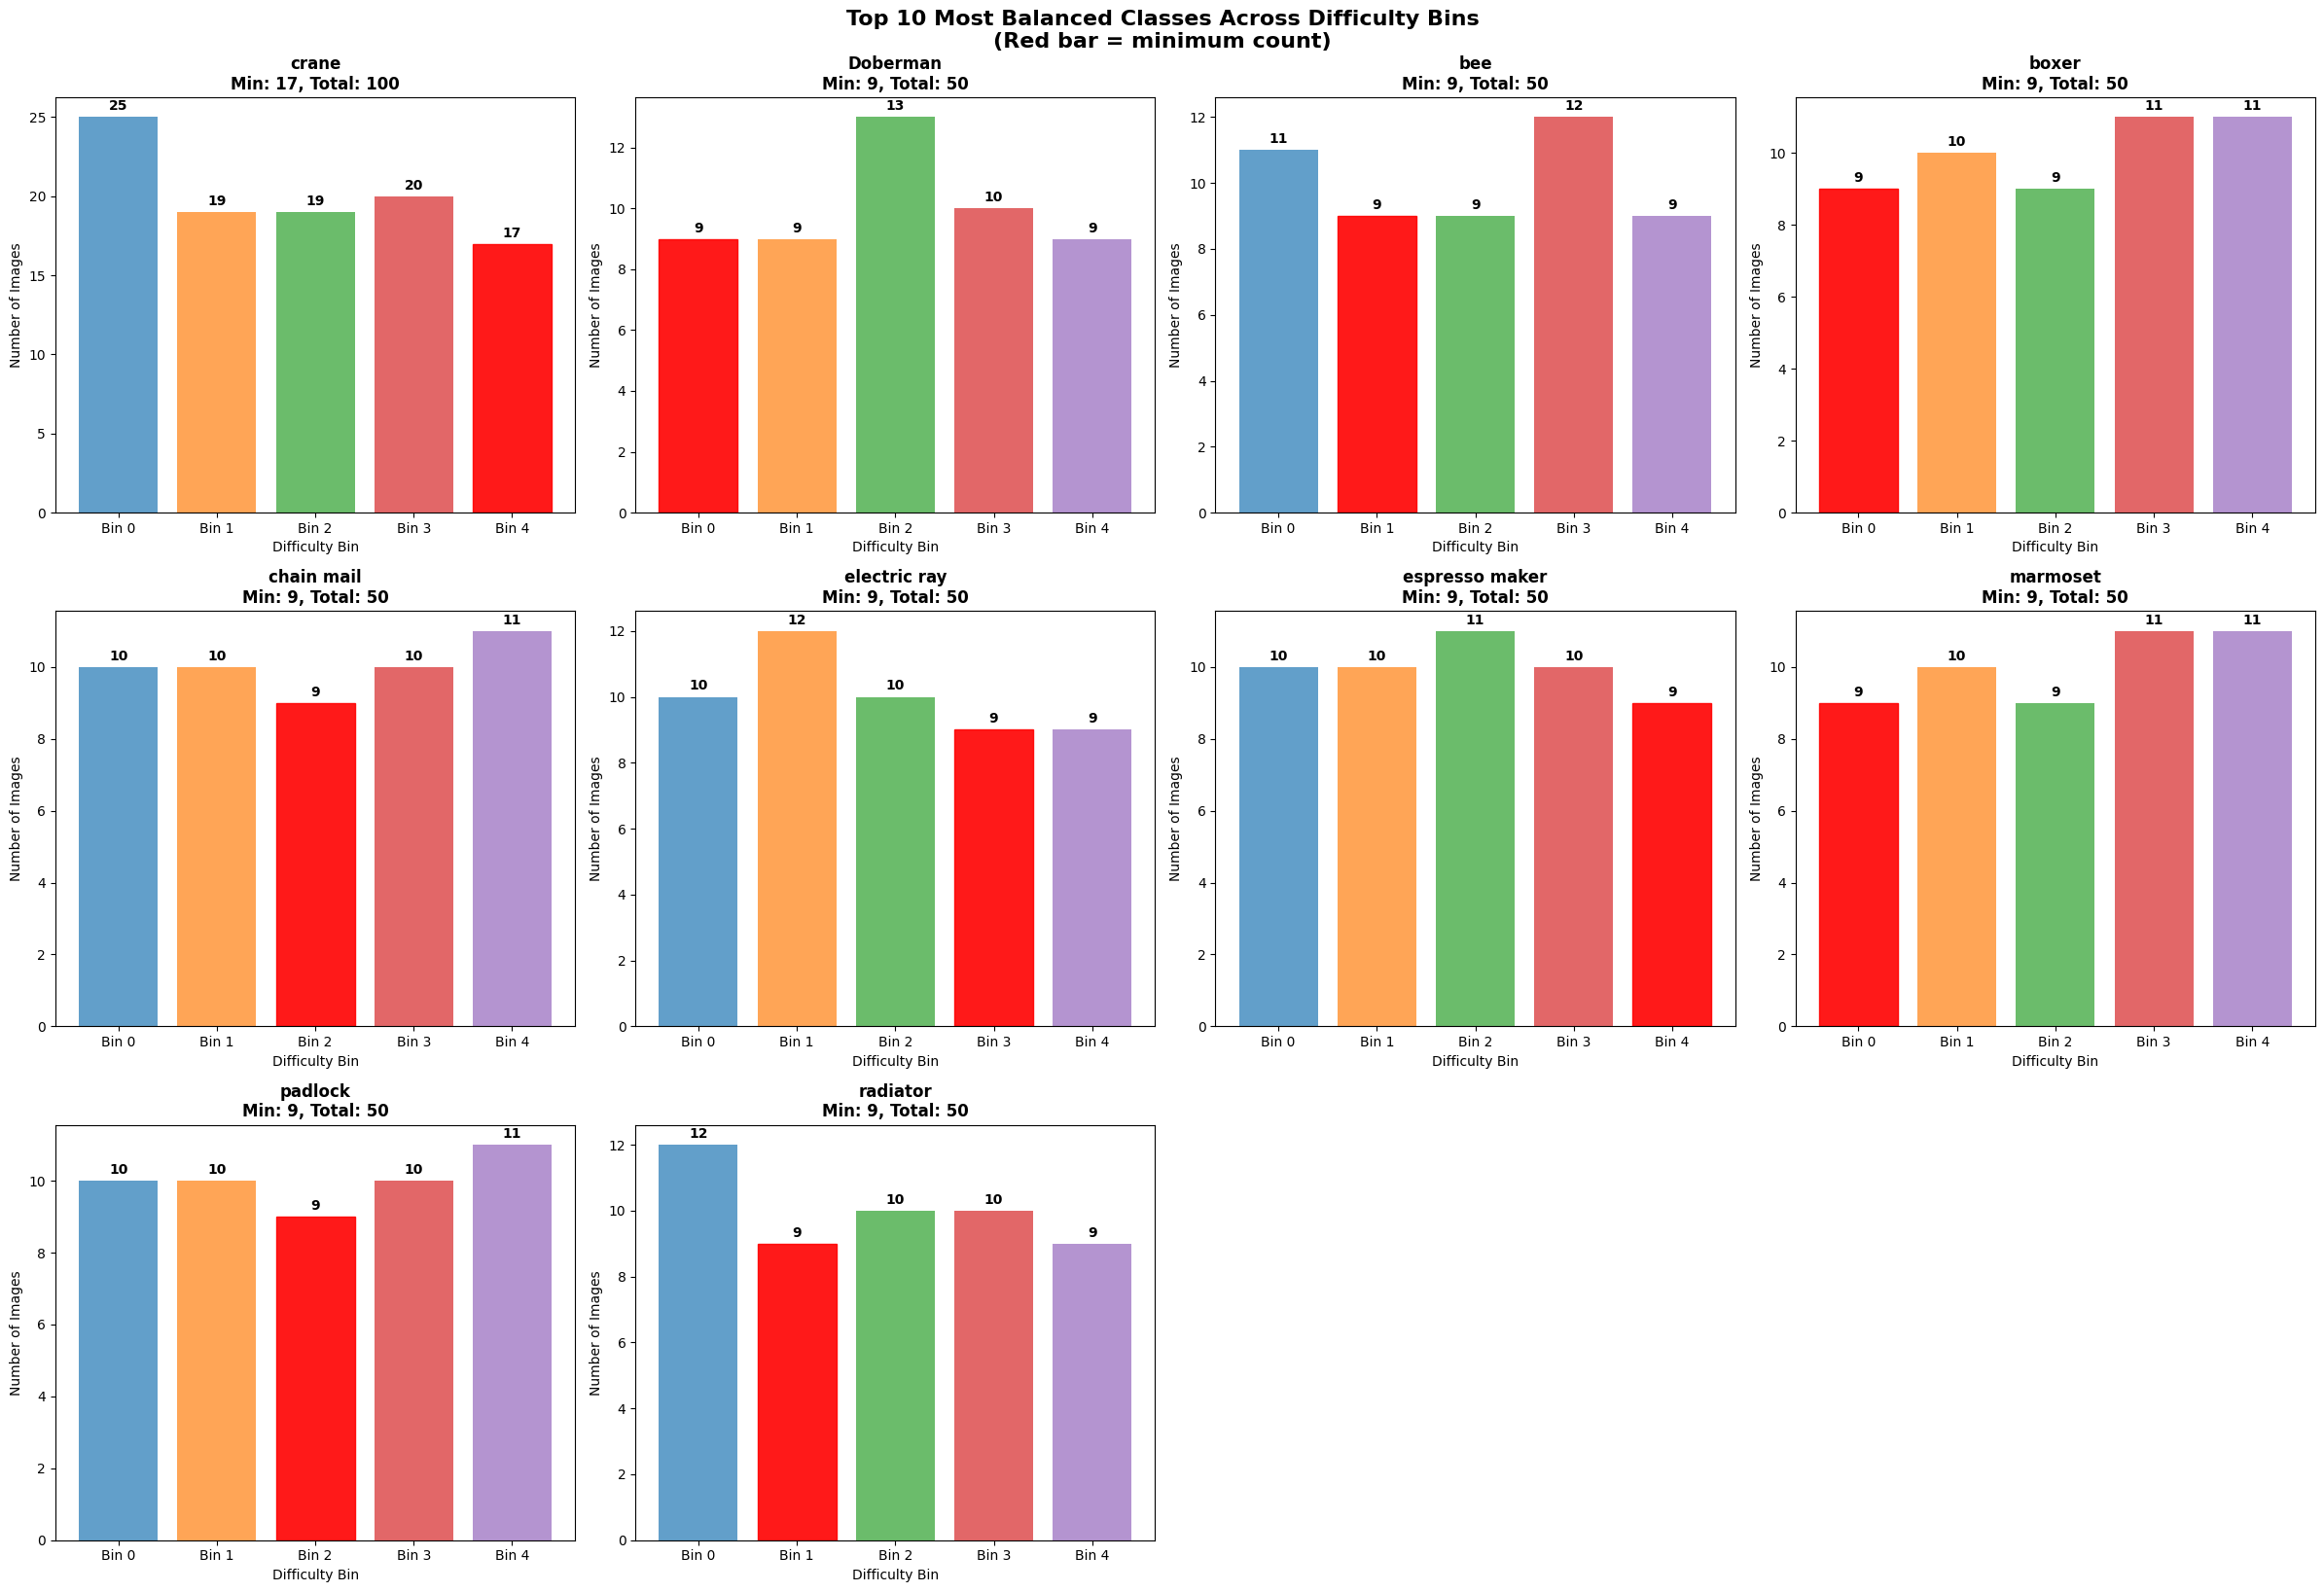

In [14]:
# Find classes with highest MINIMUM count across all bins
class_min_counts = []

for i, class_name in enumerate(all_classes):
    bin_counts = class_bin_matrix[i]
    min_count = min(bin_counts)
    total_count = sum(bin_counts)
    class_min_counts.append({
        'class_name': class_name,
        'min_count': min_count,
        'total_count': total_count,
        'bin_counts': bin_counts
    })

# Sort by minimum count (descending), then by total count
class_min_counts.sort(key=lambda x: (x['min_count'], x['total_count']), reverse=True)

# Get top 10 classes with highest minimum counts
top_10_balanced = class_min_counts[:10]

print("Top 10 classes with highest minimum count across all bins:")
for i, cls_info in enumerate(top_10_balanced):
    print(f"{i+1}. {cls_info['class_name']}: min={cls_info['min_count']}, bins={cls_info['bin_counts']}")

# Create individual histograms for these top 10 balanced classes
fig, axes = plt.subplots(3, 4, figsize=(24, 16))
axes = axes.flatten()

for i, cls_info in enumerate(top_10_balanced):
    ax = axes[i]
    
    bin_counts = cls_info['bin_counts']
    ax.bar(range(5), bin_counts, color=bin_colors, alpha=0.7)
    ax.set_title(f"{cls_info['class_name']}\nMin: {cls_info['min_count']}, Total: {cls_info['total_count']}", 
                fontweight='bold', fontsize=12)
    ax.set_xlabel('Difficulty Bin')
    ax.set_ylabel('Number of Images')
    ax.set_xticks(range(5))
    ax.set_xticklabels([f'Bin {j}' for j in range(5)])
    
    # Add count labels on bars
    for j, count in enumerate(bin_counts):
        ax.text(j, count + max(bin_counts) * 0.01, str(count), 
               ha='center', va='bottom', fontweight='bold')
    
    # Highlight the minimum value
    min_idx = bin_counts.index(cls_info['min_count'])
    ax.patches[min_idx].set_color('red')
    ax.patches[min_idx].set_alpha(0.9)

# Remove empty subplots
for i in range(10, 12):
    axes[i].remove()
plt.tight_layout()
plt.suptitle('Top 10 Most Balanced Classes Across Difficulty Bins\n(Red bar = minimum count)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()


In [15]:
# Count classes with minimum count above 6
classes_above_6 = [cls for cls in class_min_counts if cls['min_count'] > 6]
print(f"Number of classes with minimum count > 6: {len(classes_above_6)}")

# Show breakdown by minimum count
min_count_breakdown = {}
for cls in class_min_counts:
    min_val = cls['min_count']
    min_count_breakdown[min_val] = min_count_breakdown.get(min_val, 0) + 1

print("\nBreakdown by minimum count:")
for min_count in sorted(min_count_breakdown.keys(), reverse=True):
    if min_count > 0:  # Only show classes that appear in all bins
        print(f"  Min count {min_count}: {min_count_breakdown[min_count]} classes")
        if min_count <= 10:  # Show details for smaller counts
            examples = [cls['class_name'] for cls in class_min_counts if cls['min_count'] == min_count][:3]
            print(f"    Examples: {', '.join(examples)}")

print(f"\nTotal classes with min_count > 0: {sum(1 for cls in class_min_counts if cls['min_count'] > 0)}")
print(f"Classes present in all 5 bins: {len([cls for cls in class_min_counts if cls['min_count'] > 0])}")


Number of classes with minimum count > 6: 117

Breakdown by minimum count:
  Min count 17: 1 classes
  Min count 9: 11 classes
    Examples: Doberman, bee, boxer
  Min count 8: 30 classes
    Examples: Japanese spaniel, agama, ant
  Min count 7: 75 classes
    Examples: African crocodile, Cardigan, German shepherd
  Min count 6: 97 classes
    Examples: African chameleon, Airedale, Crock Pot
  Min count 5: 109 classes
    Examples: American lobster, Dungeness crab, Dutch oven
  Min count 4: 137 classes
    Examples: Brittany spaniel, Chesapeake Bay retriever, French loaf
  Min count 3: 142 classes
    Examples: American Staffordshire terrier, American alligator, American black bear
  Min count 2: 140 classes
    Examples: Afghan hound, Bedlington terrier, Blenheim spaniel
  Min count 1: 136 classes
    Examples: American chameleon, Angora, Band Aid

Total classes with min_count > 0: 878
Classes present in all 5 bins: 878


=== 2-BIN ANALYSIS ===
Total samples: 50000
First half (bin 0): indices 0-24999 (25000 samples)
Second half (bin 1): indices 25000-49999 (25000 samples)


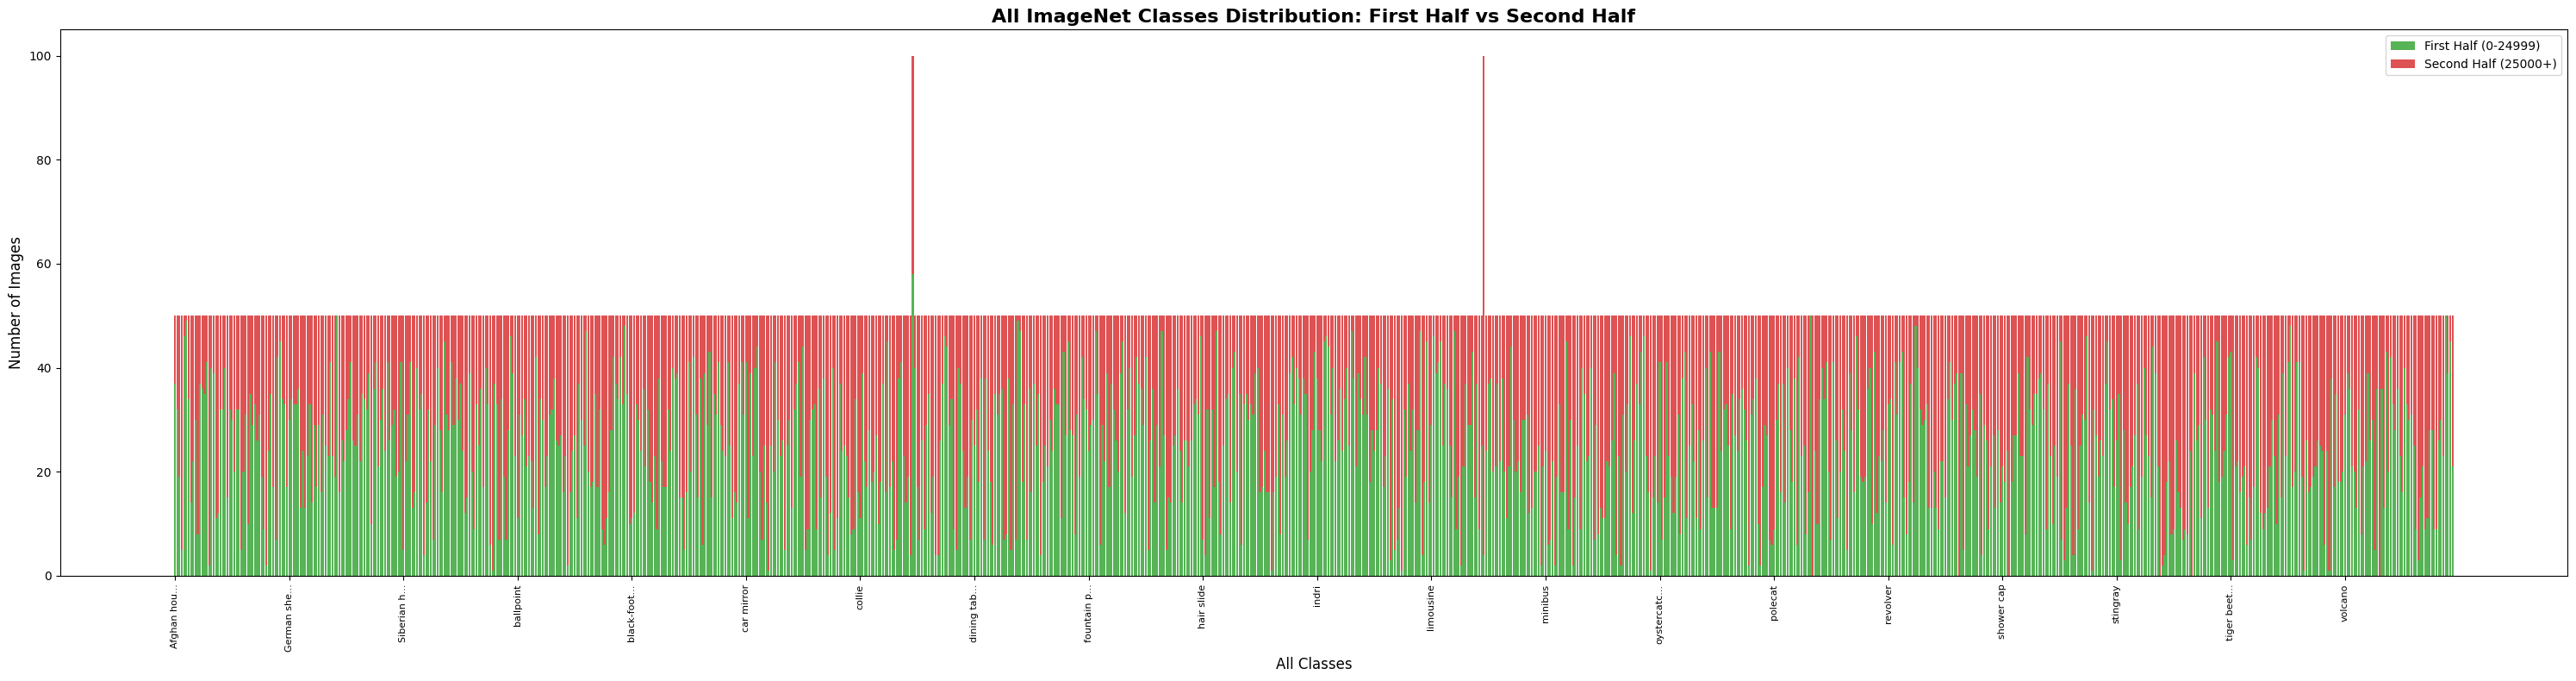

In [16]:
# 2-BIN ANALYSIS: Split into two equal halves based on original order
print("=== 2-BIN ANALYSIS ===")
total_samples = len(df)
half_point = total_samples // 2
print(f"Total samples: {total_samples}")
print(f"First half (bin 0): indices 0-{half_point-1} ({half_point} samples)")
print(f"Second half (bin 1): indices {half_point}-{total_samples-1} ({total_samples - half_point} samples)")

# Create 2-bin data based on original index position
df_2bin = df.copy()
df_2bin['difficulty_bin_2'] = df_2bin.index.map(lambda x: 0 if x < half_point else 1)

# Create histogram of ALL classes for 2-bin analysis
all_classes_2bin = sorted(df_2bin['class_name'].unique())

# Create a matrix: classes x 2 bins
class_bin_matrix_2 = []
for class_name in all_classes_2bin:
    class_data = df_2bin[df_2bin['class_name'] == class_name]
    bin_counts = [len(class_data[class_data['difficulty_bin_2'] == i]) for i in range(2)]
    class_bin_matrix_2.append(bin_counts)

# Create stacked bar chart for 2 bins
fig, ax = plt.subplots(1, 1, figsize=(30, 8))
bin_colors_2 = ['#2ca02c', '#d62728']  # Green for First Half, Red for Second Half

bottom = [0] * len(all_classes_2bin)
for bin_idx in range(2):
    counts = [class_bin_matrix_2[i][bin_idx] for i in range(len(all_classes_2bin))]
    label = 'First Half (0-24999)' if bin_idx == 0 else 'Second Half (25000+)'
    ax.bar(range(len(all_classes_2bin)), counts, bottom=bottom, 
           label=label, color=bin_colors_2[bin_idx], alpha=0.8)
    bottom = [bottom[i] + counts[i] for i in range(len(all_classes_2bin))]

ax.set_title('All ImageNet Classes Distribution: First Half vs Second Half', fontsize=16, fontweight='bold')
ax.set_xlabel('All Classes', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.legend()

# Only show every 50th class name to avoid overcrowding
tick_positions = range(0, len(all_classes_2bin), 50)
tick_labels = [all_classes_2bin[i][:10] + "..." if len(all_classes_2bin[i]) > 10 else all_classes_2bin[i] 
               for i in tick_positions]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=90, fontsize=8)

plt.tight_layout()
plt.show()


Top 10 most balanced classes for 2-bin analysis (First Half vs Second Half):
1. crane: min=42, First=58, Second=42
2. Japanese spaniel: min=25, First=25, Second=25
3. Norfolk terrier: min=25, First=25, Second=25
4. ant: min=25, First=25, Second=25
5. bassinet: min=25, First=25, Second=25
6. bee: min=25, First=25, Second=25
7. cairn: min=25, First=25, Second=25
8. cash machine: min=25, First=25, Second=25
9. castle: min=25, First=25, Second=25
10. chain mail: min=25, First=25, Second=25


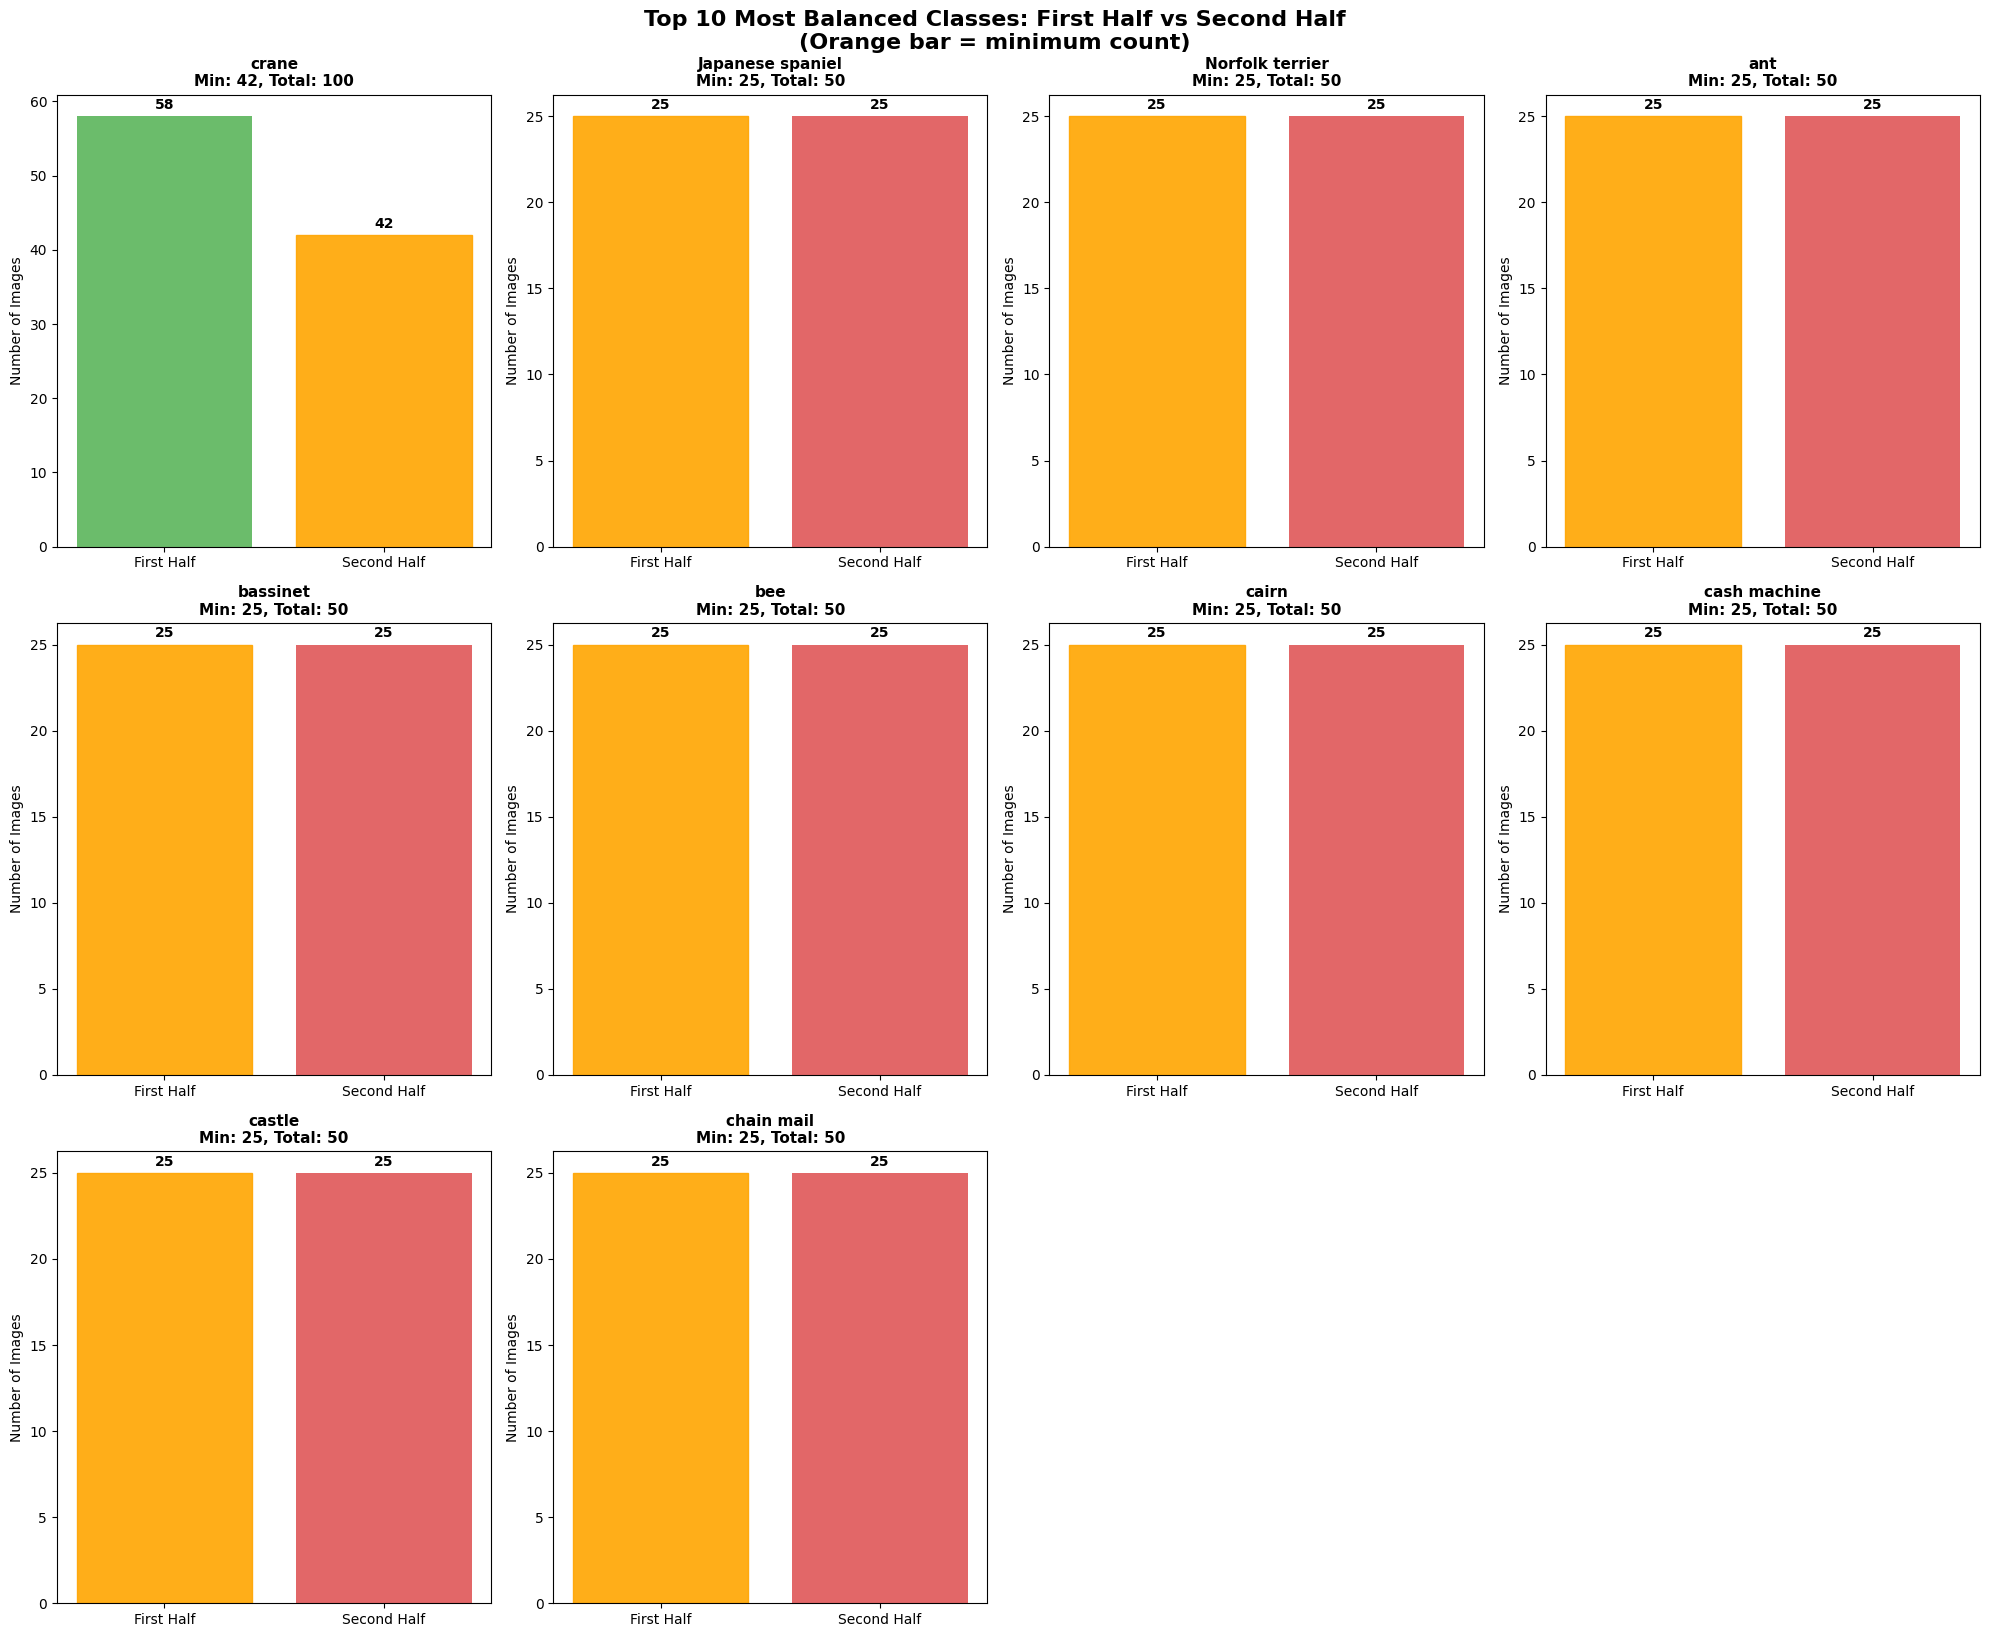


For 2-bin analysis:
Number of classes with minimum count > 15: 504
Classes present in both halves: 989


In [20]:
# Find most balanced classes for 2-bin analysis
class_min_counts_2 = []

for i, class_name in enumerate(all_classes_2bin):
    bin_counts = class_bin_matrix_2[i]
    min_count = min(bin_counts)
    total_count = sum(bin_counts)
    class_min_counts_2.append({
        'class_name': class_name,
        'min_count': min_count,
        'total_count': total_count,
        'bin_counts': bin_counts  # [easy_count, hard_count]
    })

# Sort by minimum count (descending), then by total count
class_min_counts_2.sort(key=lambda x: (x['min_count'], x['total_count']), reverse=True)

# Get top 10 classes with highest minimum counts for 2-bin
top_10_balanced_2 = class_min_counts_2[:10]

print("Top 10 most balanced classes for 2-bin analysis (First Half vs Second Half):")
for i, cls_info in enumerate(top_10_balanced_2):
    first_count, second_count = cls_info['bin_counts']
    print(f"{i+1}. {cls_info['class_name']}: min={cls_info['min_count']}, First={first_count}, Second={second_count}")

# Create individual histograms for these top 10 balanced classes (2-bin)
fig, axes = plt.subplots(3, 4, figsize=(20, 16))
axes = axes.flatten()

for i, cls_info in enumerate(top_10_balanced_2):
    ax = axes[i]
    
    bin_counts = cls_info['bin_counts']
    bars = ax.bar(['First Half', 'Second Half'], bin_counts, color=bin_colors_2, alpha=0.7)
    ax.set_title(f"{cls_info['class_name']}\nMin: {cls_info['min_count']}, Total: {cls_info['total_count']}", 
                fontweight='bold', fontsize=11)
    ax.set_ylabel('Number of Images')
    
    # Add count labels on bars
    for j, count in enumerate(bin_counts):
        ax.text(j, count + max(bin_counts) * 0.01, str(count), 
               ha='center', va='bottom', fontweight='bold')
    
    # Highlight the minimum value
    min_idx = bin_counts.index(cls_info['min_count'])
    bars[min_idx].set_color('orange')
    bars[min_idx].set_alpha(0.9)

# Remove empty subplots
for i in range(10, 12):
    axes[i].remove()

plt.tight_layout()
plt.suptitle('Top 10 Most Balanced Classes: First Half vs Second Half\n(Orange bar = minimum count)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Count classes with minimum count above 6 for 2-bin analysis
classes_above_15_2bin = [cls for cls in class_min_counts_2 if cls['min_count'] > 15]
print(f"\nFor 2-bin analysis:")
print(f"Number of classes with minimum count > 15: {len(classes_above_15_2bin)}")
print(f"Classes present in both halves: {len([cls for cls in class_min_counts_2 if cls['min_count'] > 0])}")
